## SNPE applied to SFH 

We want to infer the percentiles of stellar mass of galaxies from their spectra (whose dimensions have been reduced using an autoencoder with an attention module from 4300 points to 16-component latent vectors)

We load the modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#!pip install corner
#!pip --disable-pip-version-check install sbi


import torch
from sbi import utils as Ut
from sbi import inference as Inference
import pickle
from tqdm import tqdm

In [2]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

We load the percentiles and latent vectors

(150000, 16)
(150000, 10)


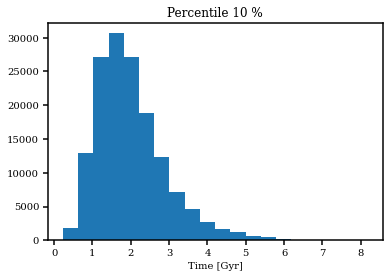

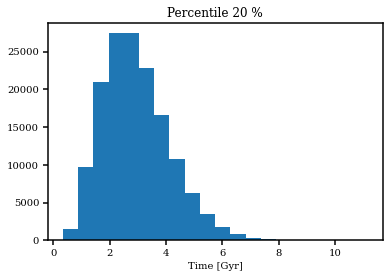

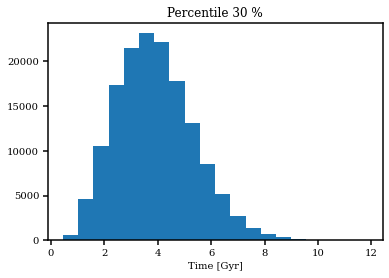

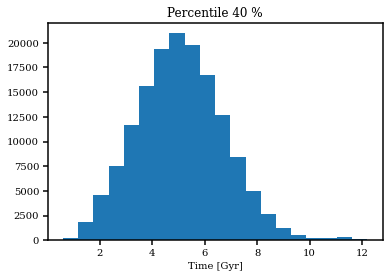

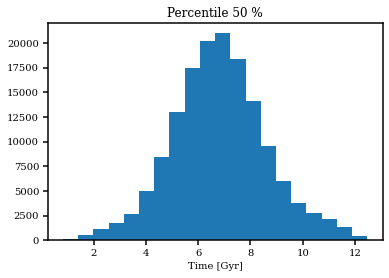

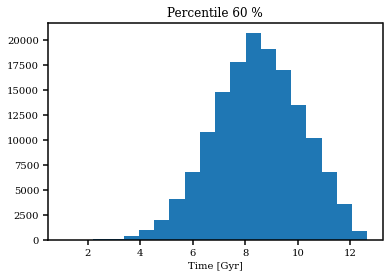

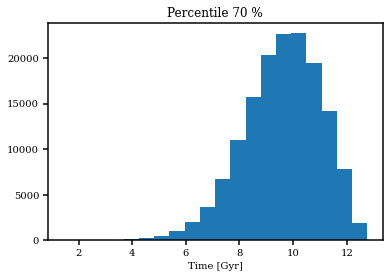

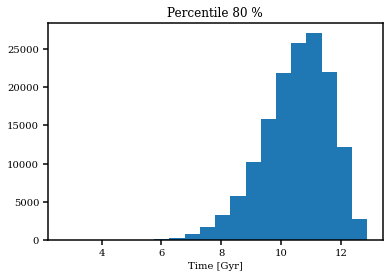

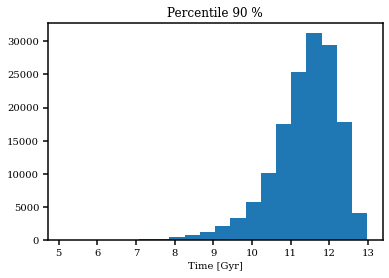

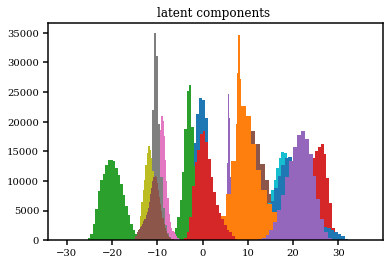

In [3]:
latents_batch=np.load('./saved_models/latents_all.npy',allow_pickle=True)
percentiles=np.load('./saved_input/y.npy',allow_pickle=True)
latents=np.zeros((150000,16))
batch_size=128

#to create a single dataset with all the minibatches
for j in range(len(latents_batch)):
    for i,x in enumerate(latents_batch[j]):
        latents[batch_size*j+i,:]=x
        
print(np.shape(latents))
print(np.shape(percentiles))

#for checking distributions
for i in range(9):
    plt.hist(percentiles[:,i],bins=20)
    plt.title('Percentile '+str((i+1)*10)+' %')
    plt.xlabel('Time [Gyr]')
    plt.show()

for i in range(16):
    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))
#plt.legend()
plt.title('latent components ')
plt.show()



IndexError: index 5 is out of bounds for axis 0 with size 5

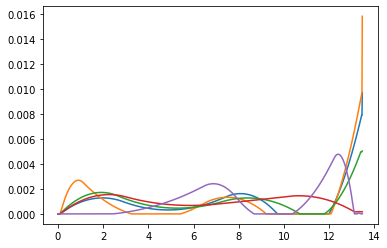

In [3]:
ms=np.load('../../seds_large/obs/ms.npy')
t=np.load('./saved_input/t.npy')

for i in range(100):
    plt.plot(t,ms[0][i])
plt.ylim(0,0.005)
plt.show()

We shuffle and save the indexes shuffled, or we just load them

In [4]:
#training with the first 405.000 elements of the dataset (previously shuffled) 

index_sh=np.load('./saved_models/ind_sh.npy')

latents=latents[index_sh,:]
percentiles=percentiles[index_sh,:]

x=latents[:135000,:]
theta=percentiles[:135000,:]


We define the range for the posterior estimation (wrongly called prior) - all of them uniformly distributed between 0 and 14

In [5]:
#percentiles
lower_bounds = -2*torch.ones(np.shape(theta[0,:]))
upper_bounds = 16*torch.ones(np.shape(theta[0,:]))

#metallicity
lower_bounds[-1]=-2.5
upper_bounds[-1]=0.6



bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

We define the model and train, then save the model

In [6]:
nhidden = 128 
nblocks = 5
maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

#anpe, amortized neural posterior estimation
anpe.append_simulations(
            torch.as_tensor(theta.astype(np.float32)).to('cpu'),
            torch.as_tensor(x.astype(np.float32)).to('cpu'))  

import time

start=time.time()
# estimate p(theta|X), the posterior
p_theta_x_est = anpe.train(learning_rate=5e-4,show_train_summary=True)
end=time.time()
qphi = anpe.build_posterior(p_theta_x_est)


print(end-start, ' s')

 Neural network successfully converged after 185 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 185
        Best validation performance: 28.1001
        -------------------------
        
9340.366055965424  s


Save posterior or load it

In [8]:
file="./saved_models/my_posterior.pkl"

with open(file, "wb") as handle:
    pickle.dump(qphi, handle)

handle.close()
"""
file = open(file, 'rb')
qphi = pickle.load(file)
file.close()
"""

"\nfile = open(file, 'rb')\nqphi = pickle.load(file)\nfile.close()\n"

We create a function to see real vs predicted percentiles (we plot the mean and the interval of confidence: sigma, 2sigma... of the posteriors) for the test dataset (10.000 samples)

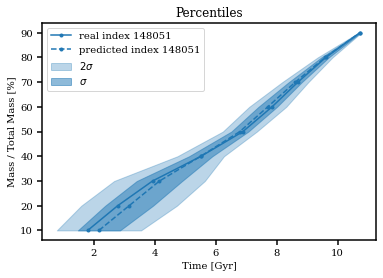

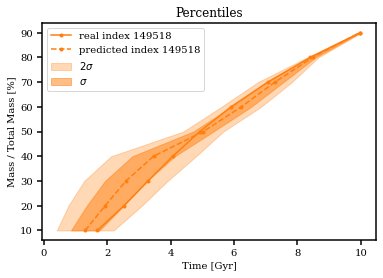

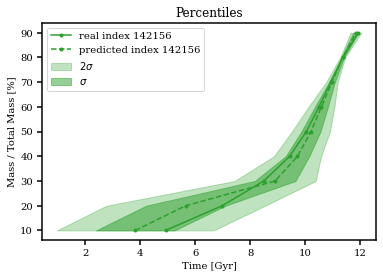

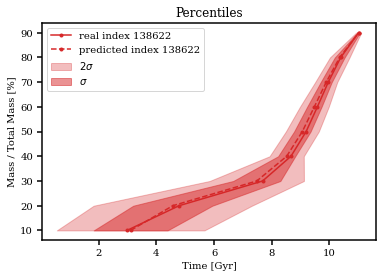

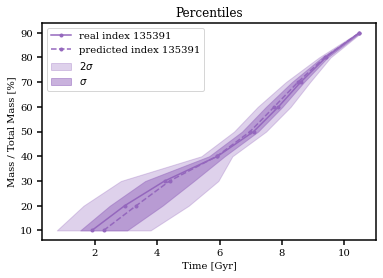

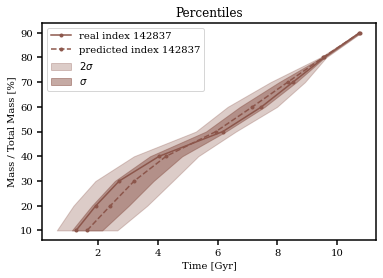

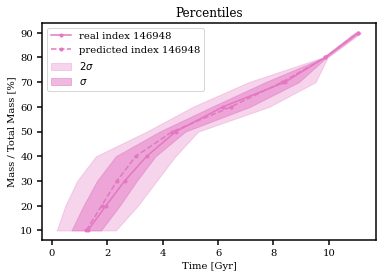

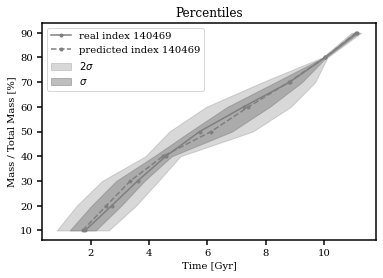

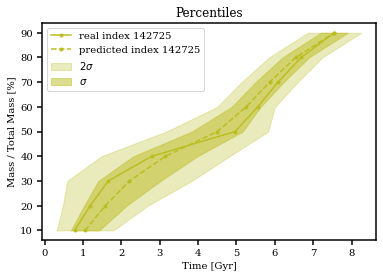

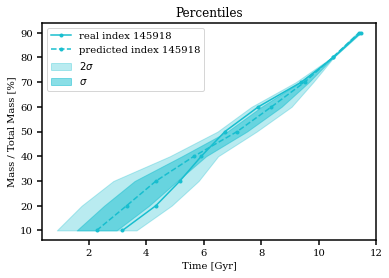

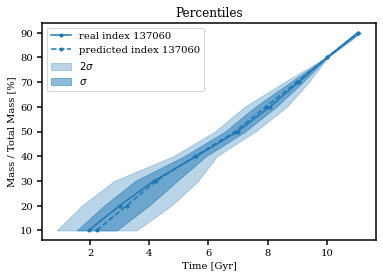

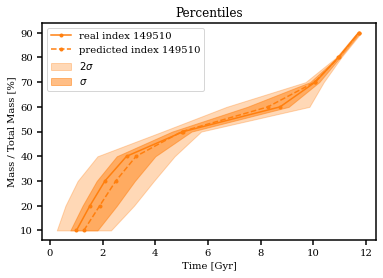

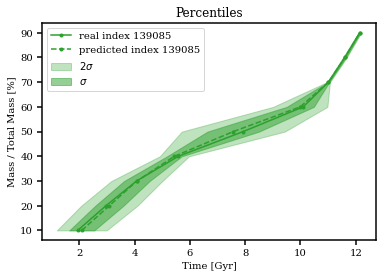

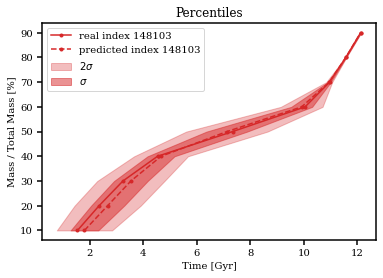

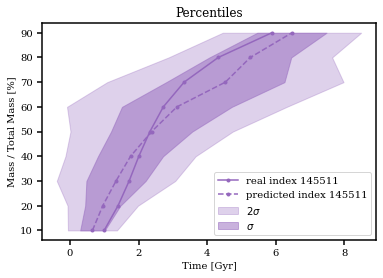

In [9]:
def plot_percentile_distribution(i,index_list=np.random.randint(135000,150000,15),mean=False,real_plot=False):
    
    if i==None:
        for k,j in enumerate(index_list):
                
                Xobs=latents[j,:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))
                
                plt.plot(percentiles[j,:9],np.arange(10,100,10),'.-',color='C'+str(k),label='real index '+str(j))
                plt.plot(np.mean(posterior_samples,axis=0)[:9],np.arange(10,100,10),'.--',color='C'+str(k),label='predicted index '+str(j))
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+2*np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-2*np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
                plt.title('Percentiles')
                plt.legend()
                plt.xlabel('Time [Gyr]')
                plt.ylabel('Mass / Total Mass [%]')
                #plt.savefig('prediction_1e5_m216_'+str(k)+'.jpg')
                plt.show()

        
    else:
         for k,j in enumerate(index_list):
                
                Xobs=latents[j,:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))

                plt.hist(posterior_samples[:,i-1],alpha=0.5,color='C'+str(k),label='index '+str(j))

                if mean:
                    plt.axvline(np.mean(posterior_samples[:,i-1]),ls='--',color='C'+str(k))
                    plt.axvline(percentiles[j,i-1],ls='-',color='C'+str(k))
         
        
         plt.title('percentil posterior ' +str(i*10)+'%')
         #plt.legend()
         plt.xlabel('Time [Gyr]')
         plt.show()
            
         if real_plot:
            for k,j in enumerate(index_list):
                plt.plot(percentiles[j,:9],np.arange(10,100,10),'.-',color='C'+str(k),label='index '+str(j))
            plt.title('Real percentiles')
            plt.xlabel('Time [Gyr]')
            plt.ylabel('Mass / Total Mass [%]')
            #plt.legend()
            plt.show()
    

    
#plot_percentile_distribution(1,mean=True)
#plot_percentile_distribution(5,mean=True)
#plot_percentile_distribution(9,mean=True,real_plot=True)
plot_percentile_distribution(None)

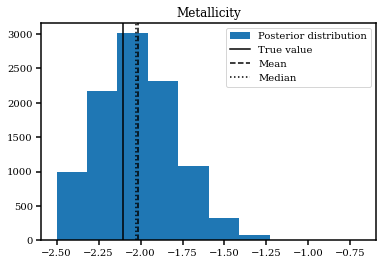

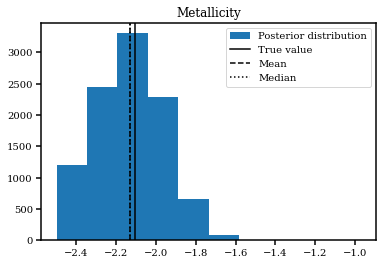

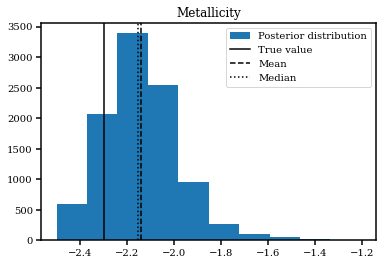

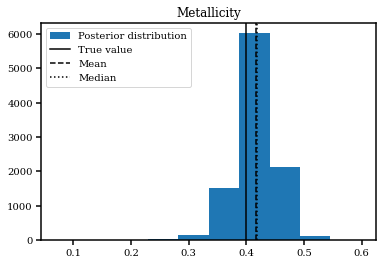

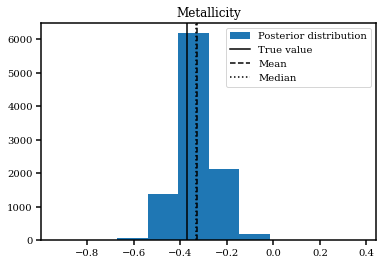

In [9]:
index_list=np.random.randint(135000,150000,5)

for k,j in enumerate(index_list):
                Xobs=latents[j,:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))

                plt.hist(posterior_samples[:,-1],label='Posterior distribution')
                plt.axvline(percentiles[j,-1],ls='-',c='k',label='True value')
                plt.axvline(np.mean(posterior_samples[:,-1]),ls='--',c='k',label='Mean')
                plt.axvline(np.median(posterior_samples[:,-1]),ls=':',c='k',label='Median')
                plt.title('Metallicity')
                plt.legend()
                plt.show()

               

We plot the mean of the predicted posteriors (and save it after computed) vs the ground truth

In [10]:
n_evaluations=15000
n_samples=1000
index_list=np.arange(135000,150000)

stds=[]
means=[]

for k,j in tqdm(enumerate(index_list)):
    Xobs=latents[j,:]
    posterior_samples= np.array(qphi.sample((n_samples,), x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), show_progress_bars=False).detach().to('cpu'))
    stds.append(np.std(posterior_samples,axis=0))
    means.append(np.median(posterior_samples,axis=0))
    
    
np.save('./saved_models/means.npy',means)
np.save('./saved_models/stds.npy',stds)

15000it [5:19:27,  1.28s/it] 


In [11]:
#COMPUTE ACCURACY

index_list=np.arange(135000,150000)
means=np.load('./saved_models/means.npy')
stds=np.load('./saved_models/stds.npy')

accuracy=[]
for i in range(10):
    if i<9:
        p0=np.where(percentiles[index_list,i]>1e-1)[0]
        accuracy.append(100-np.mean(np.abs(means[:,i][p0]-percentiles[index_list,i][p0])/np.abs(percentiles[index_list,i][p0]) * 100))
    else:
        accuracy.append(100-np.mean(np.abs(means[:,i]-percentiles[index_list,i])/np.abs(percentiles[index_list,i]) * 100))

print(accuracy)

[77.64898673409812, 79.81268243178944, 84.58800284273767, 90.6759345763381, 92.55079874375568, 95.57977425686444, 98.36585936345624, 99.59427652268774, 99.70310088668158, 86.79806139382082]


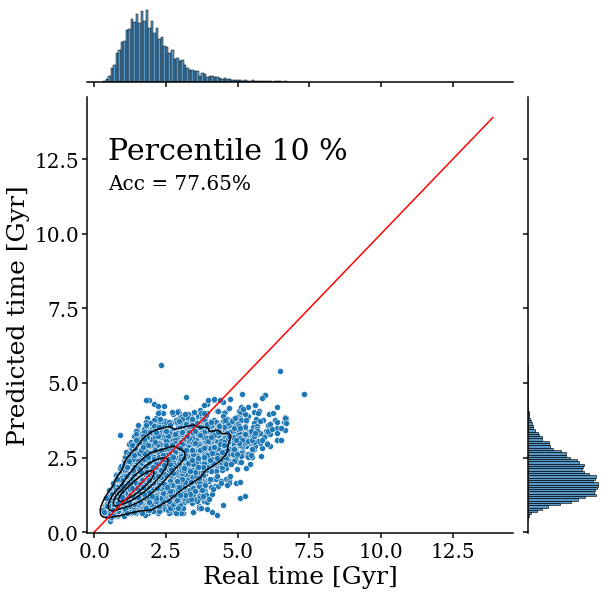

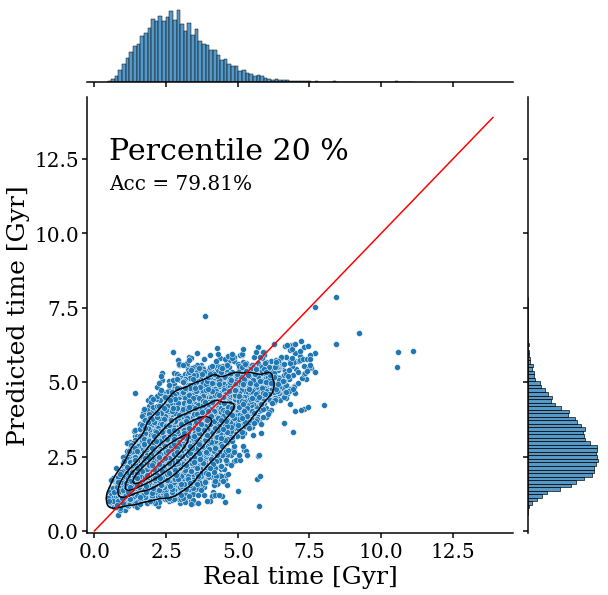

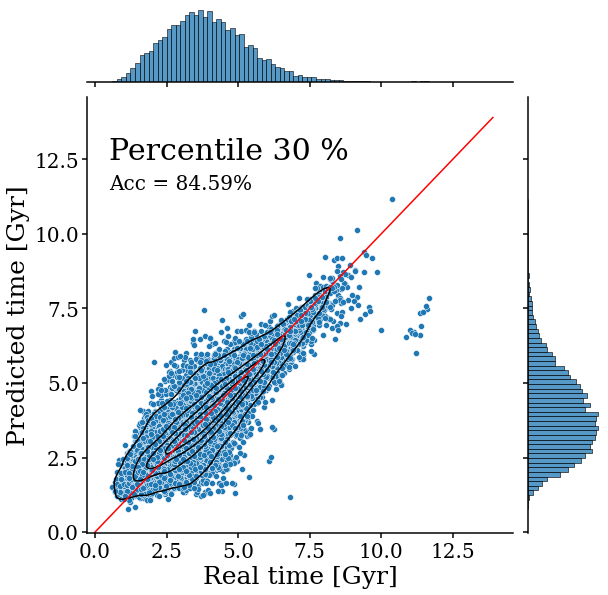

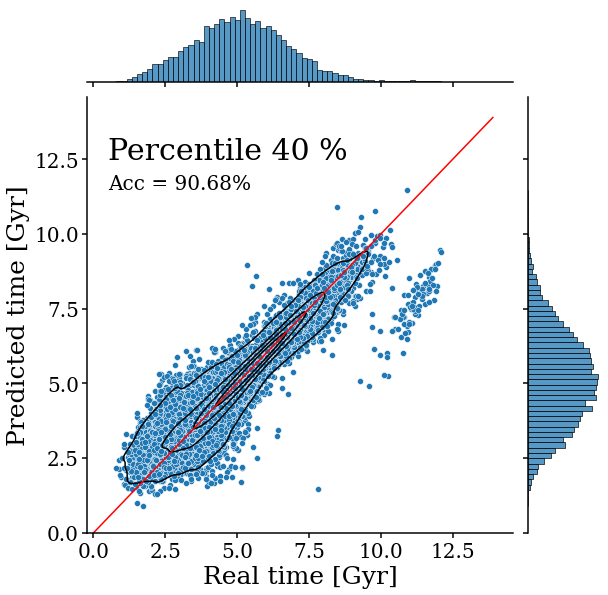

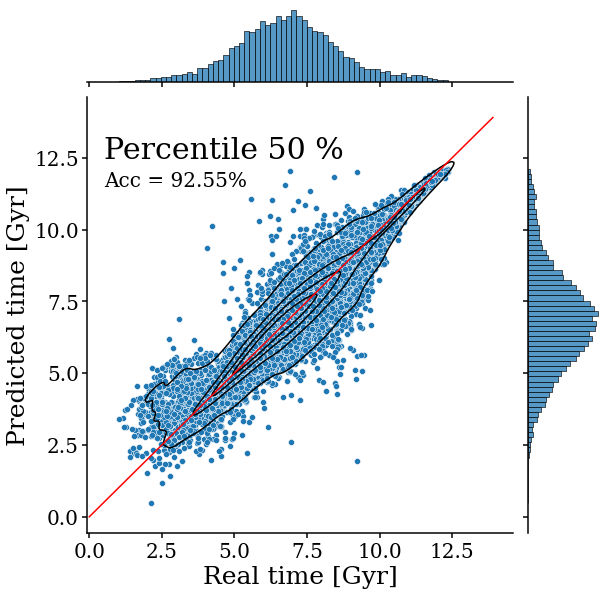

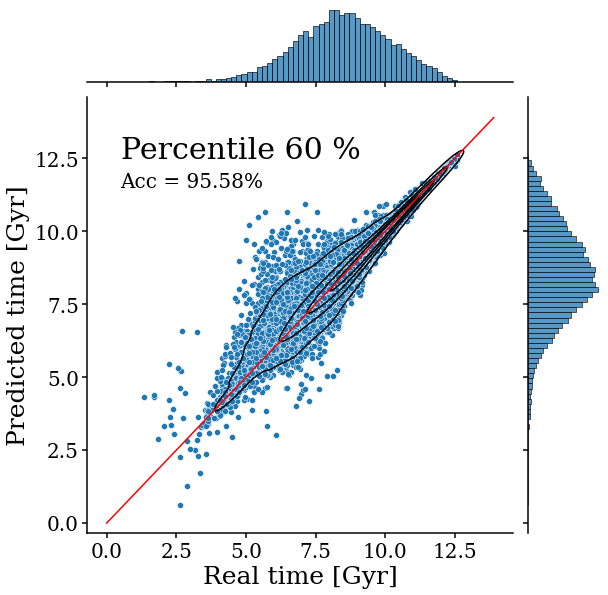

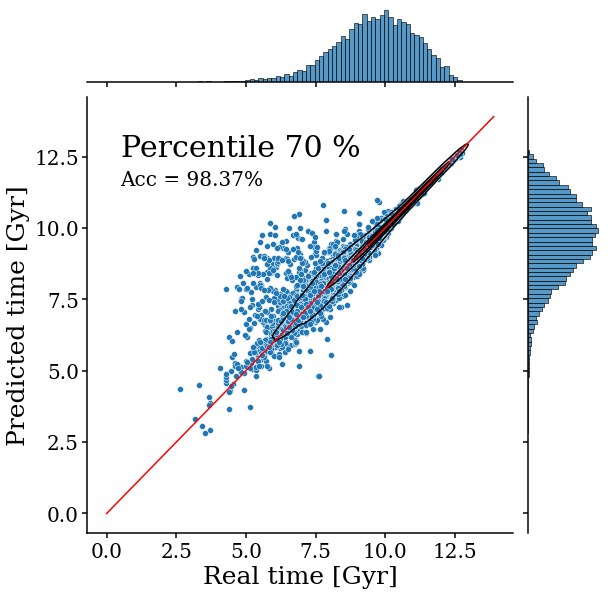

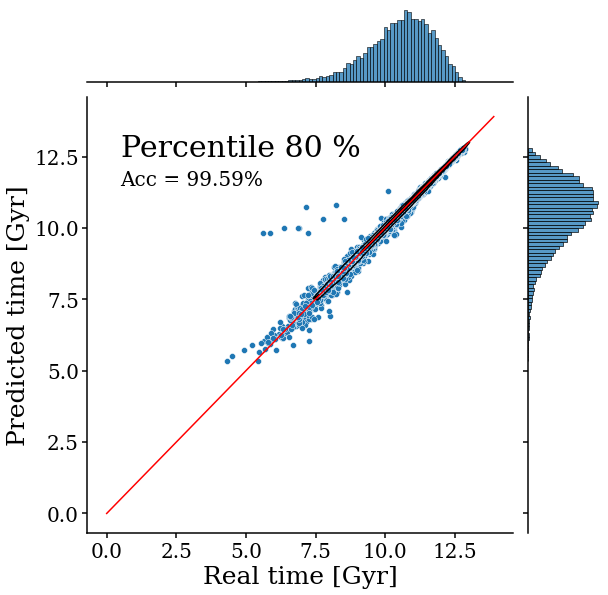

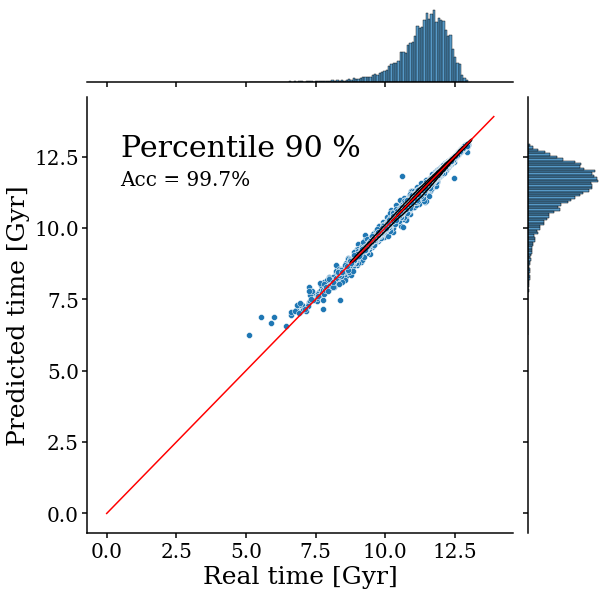

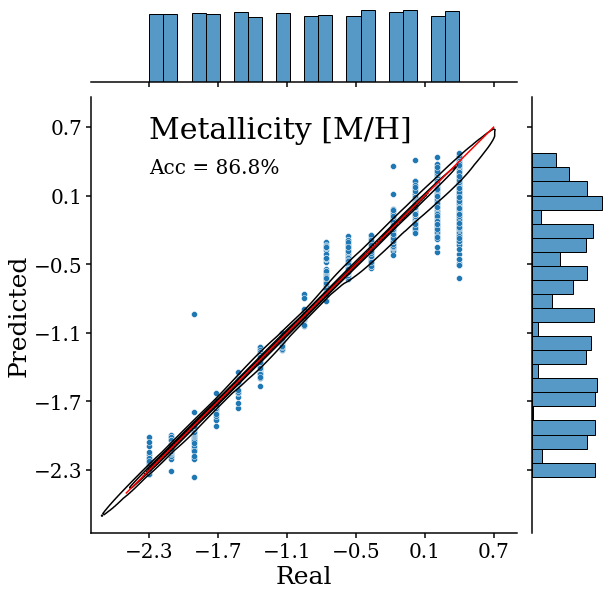

In [12]:
index_list=np.arange(135000,150000)
means=np.load('./saved_models/means.npy') #change if needed
stds=np.load('./saved_models/stds.npy')

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20


import seaborn as sns

for i in range(10):  #[0,4,8,9]
    
    p=percentiles[index_list,i]

    if i<9:
        g=sns.jointplot(x=p, y=means[:,i],height=8,label='Test data',legend=False)#kind='reg')
        x=np.arange(0,14,0.1)
        kde=g.plot_joint(sns.kdeplot, color="k", zorder=1, levels=5,label='KDE')
        d=g.ax_joint.plot(x, x, '-r',label='y=x')
        #if i==0:
            #g.ax_joint.legend(*g.ax_joint.get_legend_handles_labels(),prop={'size': 20})._set_loc(4)
            #g.ax_joint.legend(['Test data','KDE','y=x'],prop={'size': 20})._set_loc(4)
            #plt.legend(*g.ax_joint.get_legend_handles_labels(),fontsize=20,loc='upper left')
            #plt.legend(['Test data','KDE','y=x'],fontsize=20)
        g.set_axis_labels('Real time [Gyr]','Predicted time [Gyr]',fontsize=25)
        g.ax_joint.set_xticks(np.arange(0,15,2.5))
        g.ax_joint.set_yticks(np.arange(0,15,2.5))
        g.ax_joint.text(0.5,12.5,'Percentile '+str((i+1)*10)+' %',fontsize=30)
        g.ax_joint.text(0.5,11.5,'Acc = '+str(np.around(accuracy[i],2))+'%',fontsize=20)
        
    
    elif i==9:
        g=sns.jointplot(x=p, y=means[:,i],height=8,label='Test',legend=False)#,kind='kde')
        kde=g.plot_joint(sns.kdeplot, color="k", zorder=1, levels=5, label='KDE')
        x=np.arange(-2.5,0.8,0.1)
        d=g.ax_joint.plot(x, x, '-r',label='y=x')
        g.set_axis_labels('Real',
        'Predicted',fontsize=25)
        g.ax_joint.set_xticks([-2.3,-1.7,-1.1,-0.5,0.1,0.7])
        g.ax_joint.set_yticks([-2.3,-1.7,-1.1,-0.5,0.1,0.7])
        g.ax_joint.text(-2.3,0.6,'Metallicity [M/H]',fontsize=30)
        g.ax_joint.text(-2.3,0.3, 'Acc = '+str(np.around(accuracy[i],2))+'%',fontsize=20)
    #g.savefig('sns_mean_true_kde_6_'+str(i)+'.jpg')
    plt.show()

Corner plot

0it [00:00, ?it/s]

index:  74100


1it [00:06,  6.53s/it]

index:  25041


2it [00:08,  3.61s/it]

index:  79034


3it [00:09,  2.59s/it]

index:  56952


4it [00:10,  2.13s/it]

index:  126186


5it [00:12,  2.51s/it]


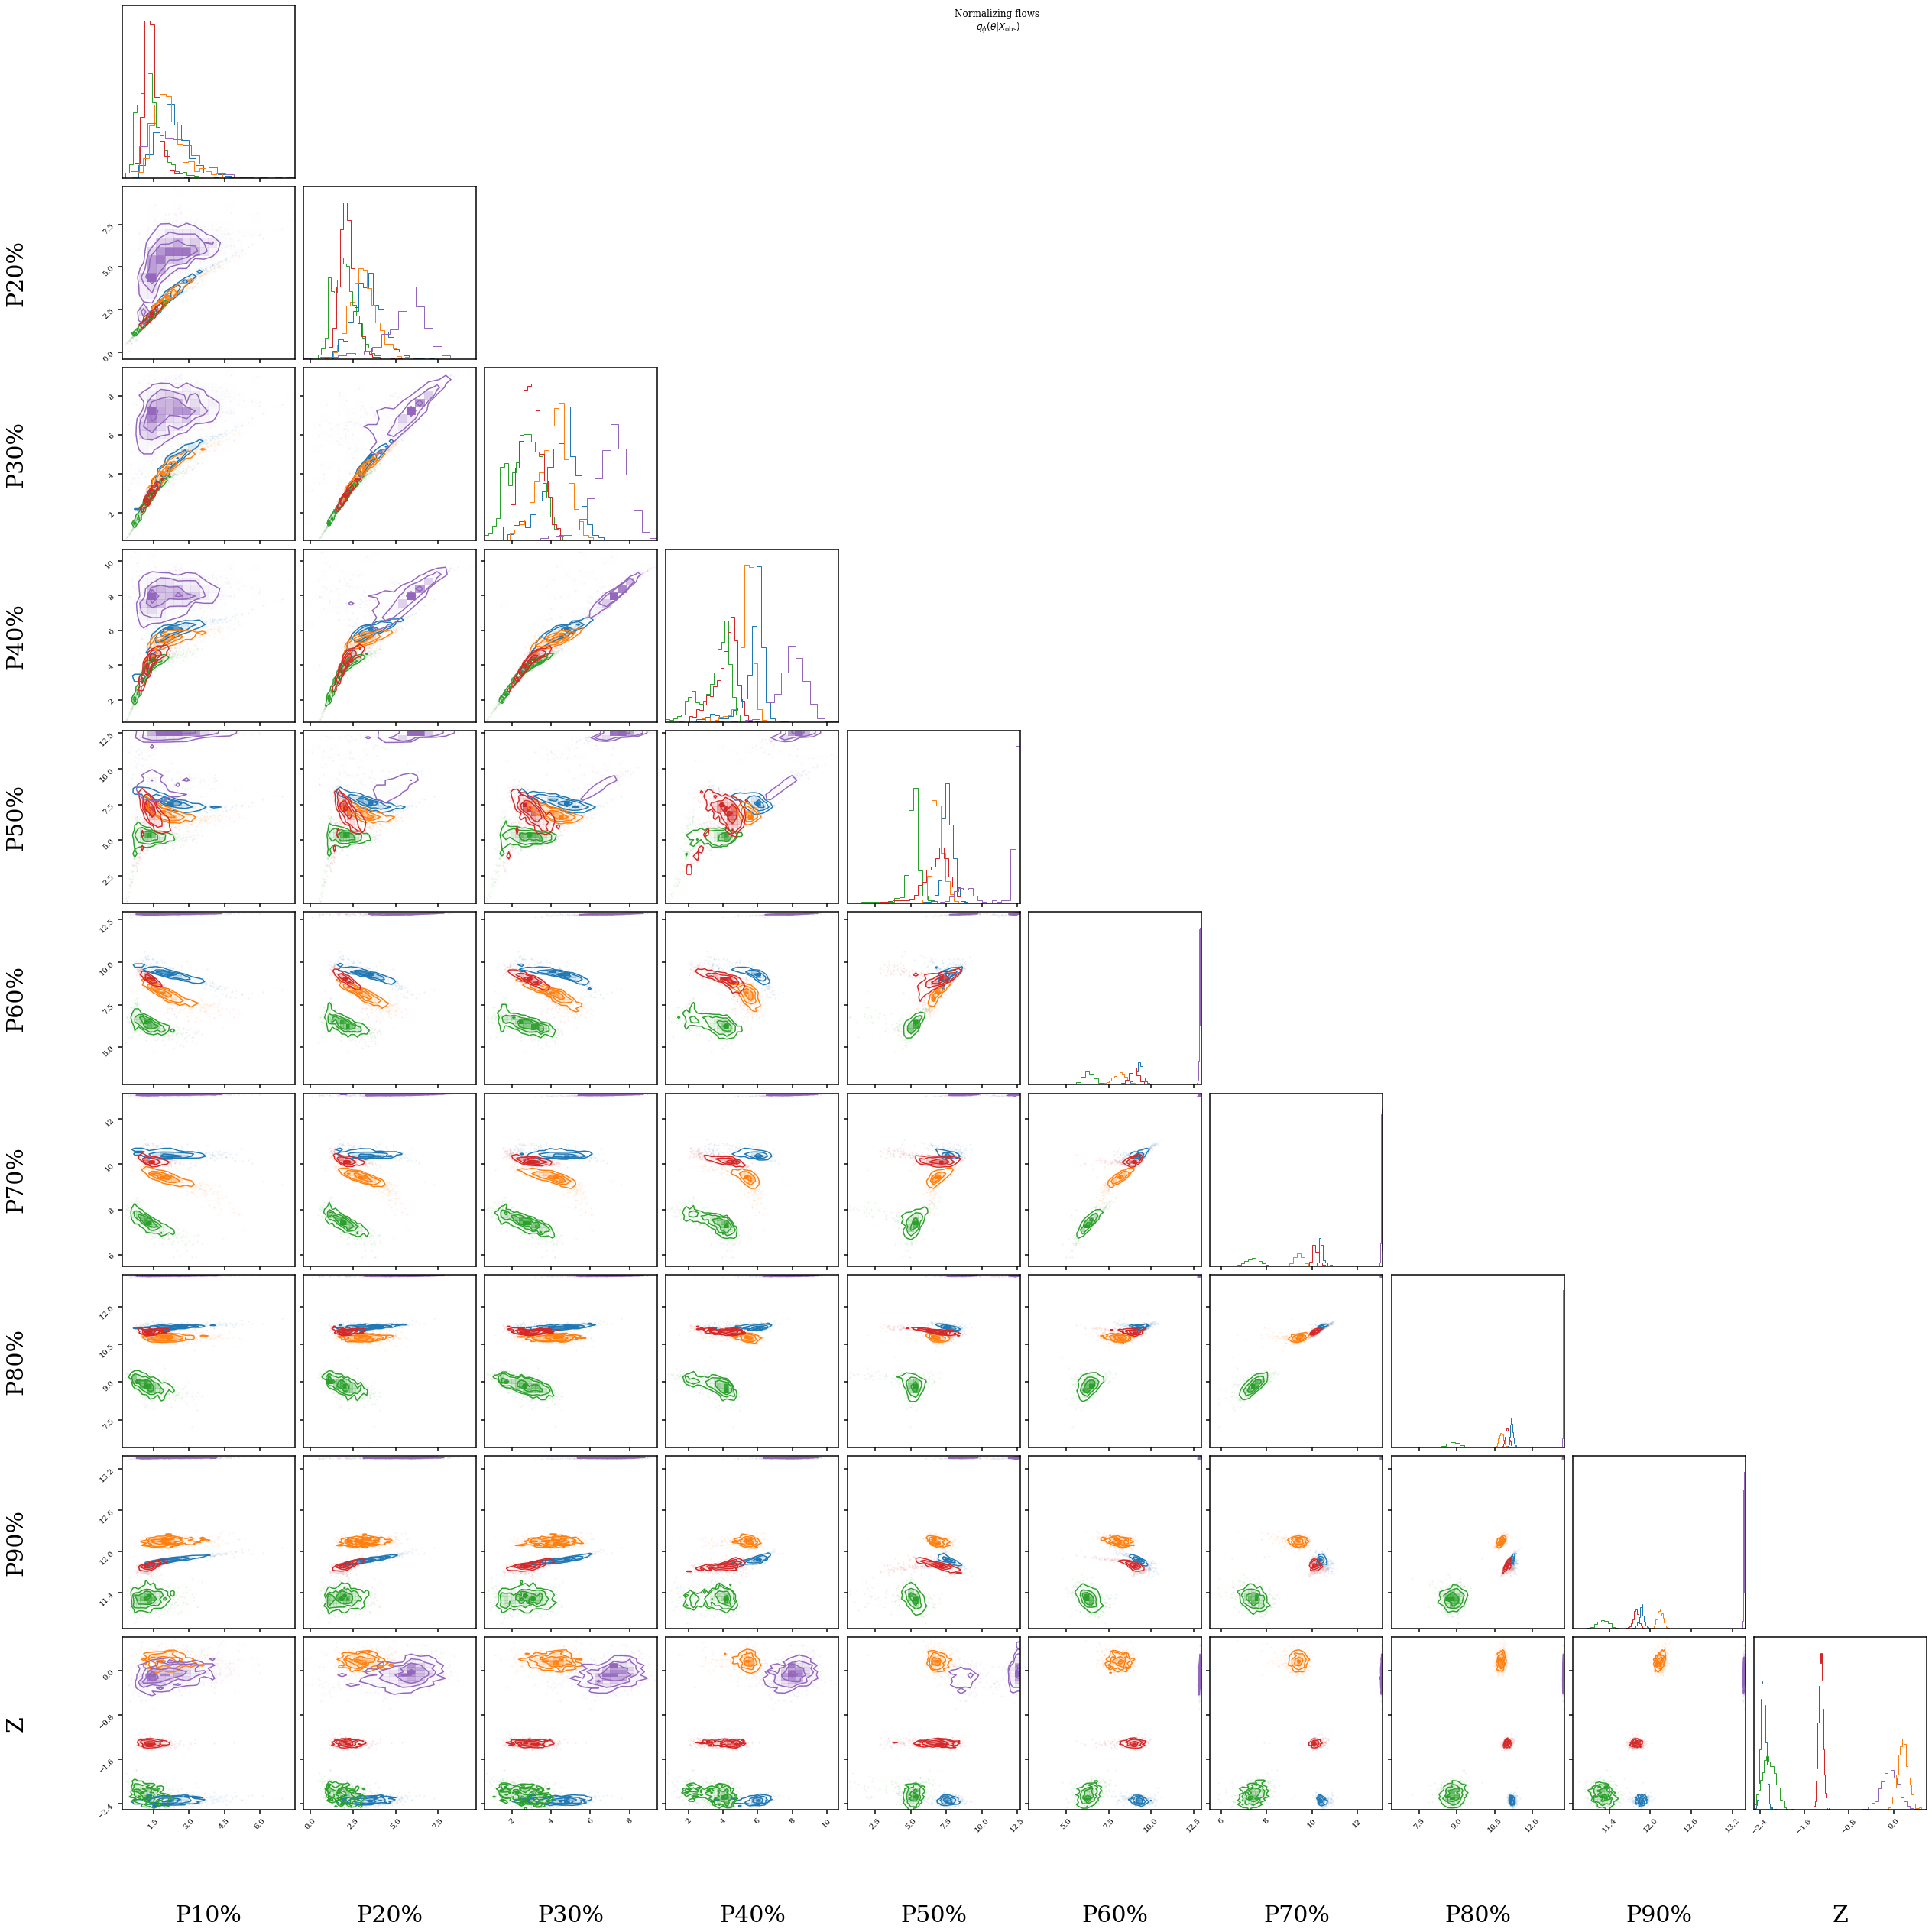

In [14]:
#all percentiles together

import corner

best_list=np.random.randint(135000,150000,5)


fig=plt.figure(figsize=(35,35))
posteriors=[]

for k,j in tqdm(enumerate(best_list)):
    print('index: ',index_sh[j])
    Xobs=latents[index_sh[j],:]
    posterior_samples = np.array(qphi.sample((1000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))
    posteriors.append(posterior_samples)
    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['P'+str(i*10)+'%' for i in range(1,12)] #label for percentiles
    lt[-2]='Z'
    lt[-1]='[$\\alpha$/Fe]'

    #we plot all the percentiles
    _ = corner.corner(posterior_samples[:,:], 
                      labels=lt,
                      label_kwargs={'fontsize': 30, 'fontname':'serif'},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig,labelpad=0.25)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(index_sh[j]))
    
#plt.legend(loc='upper left')
fig.suptitle('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$')
#fig.savefig('corner.jpeg')
plt.show()